# Курс Глубокое обучение в компьютерном зрении


# Урок 6. Metric Learning

# Задание
Обучить сиамскую сеть для верификации лиц на датасете LFW

* Библиотеки: [Python, Tensorflow]

# Решение

## Подключение библиотек и скриптов

In [1]:
# Переключение версии TensorFlow
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

import tensorflow as tf
import tensorflow_datasets as tfds

## Загрузка и подготовка датасета LFW

In [3]:
(train_ds, test_ds), ds_info = tfds.load(
    'lfw',
    split=['train[:90%]','train[90%:]'],
    as_supervised=True,
    with_info = True
)

In [4]:
tfds.builder('lfw').info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [5]:
len(train_ds), len(test_ds)

(11910, 1323)

## Визуализация датасета LFW

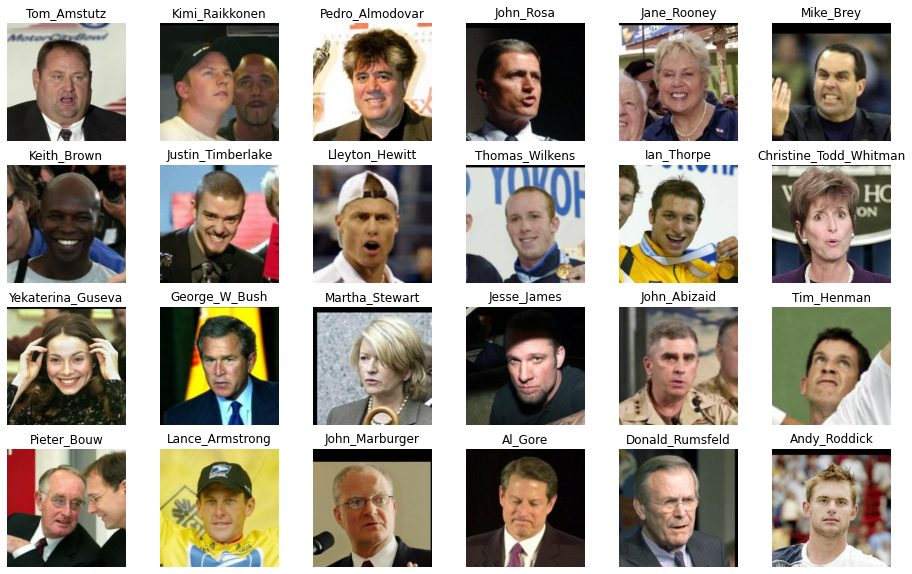

In [6]:
plt.figure(figsize=(16, 10))
for j, x in enumerate(train_ds.take(24)):
    plt.subplot(4, 6, j+1)
    plt.title(x[0].numpy().decode('utf-8'))
    plt.imshow(x[1])
    plt.axis('off')

## Создание модели CNN

In [7]:
EMB_SIZE = 64

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Conv2D(64, (5, 5), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D((2, 2), (2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(EMB_SIZE, activation=None),
])

## Contrastive Loss

In [8]:
MARGIN = 10.0

def contastive_loss(embs, labels):
    bs = embs.shape[0]
    embs1 = embs[:bs//2, ...]
    embs2 = embs[bs//2:, ...]
    labels1 = labels[:bs//2]
    labels2 = labels[bs//2:]

    d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
    d =  tf.sqrt(d2)
    z = tf.cast(labels1 == labels2, tf.float32)
    
    return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

## Подготовка пайплайна данных

In [9]:
BATCH_SIZE = 64
NUM_EPOCHS = 5

def normalize_img(label, image):
  return label, tf.cast(image, tf.float32) / 255.

train_ds = train_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

test_ds = test_ds.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(1)

## Подготовка к обучению

In [10]:
LEARNING_RATE = 0.001
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

## Обучение модели

In [12]:
%%time

for iteration, (labels, images) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        embs = model(images)
        loss_value = contastive_loss(embs, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.variables)
    optimizer.apply_gradients(zip(grads, model.variables))

    if iteration % 100 == 0:
        # print('[{}] Loss: {}'.format(iteration, loss_value.numpy()))
        print(f'[{iteration}]\t loss: {loss_value.numpy():.4f}\t')

[0]	 loss: 314.5780	
[100]	 loss: 3.0246	
[200]	 loss: 0.0000	
[300]	 loss: 0.1111	
[400]	 loss: 0.5675	
[500]	 loss: 5.4566	
[600]	 loss: 0.1288	
[700]	 loss: 0.0488	
[800]	 loss: 0.4972	
[900]	 loss: 0.0000	
CPU times: user 3min 3s, sys: 5.77 s, total: 3min 8s
Wall time: 3min 42s


## Получение эмбеддингов для тестовой выборки

In [13]:
test_y = np.array([])
test_embs = tf.concat([model(images) for _, images in test_ds], 0)

for labels, images in test_ds:
    test_y = np.append(test_y, labels.numpy()[0])

In [14]:
test_y.shape

(1323,)

## Функция для визуализации эмбеддингов

In [19]:
def draw_embeddings(X_embedded, targets):
    plt.figure(figsize=(10, 10)
    for class_idx in np.unique(targets)[:24]:
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:,0], X_embedded_class[:,1], label=class_idx)
        plt.legend()
    plt.grid(True)

## Визуализация эмбеддингов в 2D пространстве с помощью TSNE

In [16]:
test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
labels_for_viz = test_y

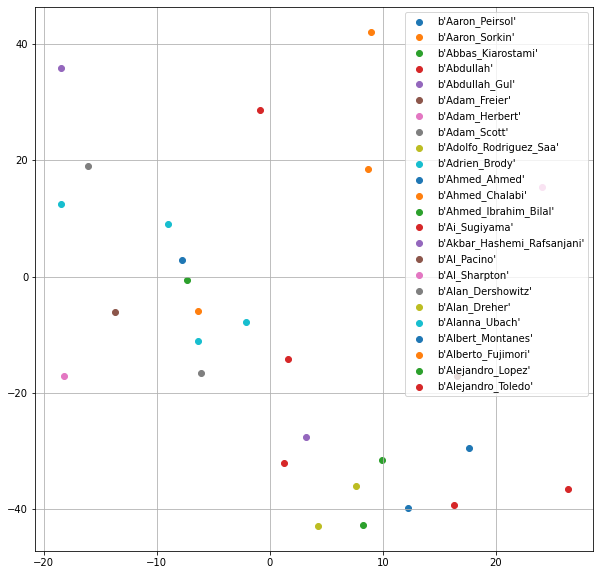

In [20]:
draw_embeddings(test_embs_2D, labels_for_viz)

## Тестирование на новых данных

In [36]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [37]:
data_path = '/content/drive/My Drive/Colab Notebooks/116_ComputerView/less_06/hw_06/'

In [39]:
def load_and_prepare_image(fpath):
    import imageio
    from skimage.transform import resize
    img = imageio.imread(fpath, pilmode="RGB")
    img = img.astype(np.float32)/255
    img = resize(img, (250, 250), order=3, mode='reflect', anti_aliasing=True)
    img = np.reshape(img, (250, 250, 3))
    return img

img_a1 = load_and_prepare_image(data_path + 'face1.jpg')
img_a2 = load_and_prepare_image(data_path + 'face2.jpg')
img_a3 = load_and_prepare_image(data_path + 'face3.jpg')
img_b1 = load_and_prepare_image(data_path + 'face4.jpg')
img_c1 = load_and_prepare_image(data_path + 'face5.jpg')

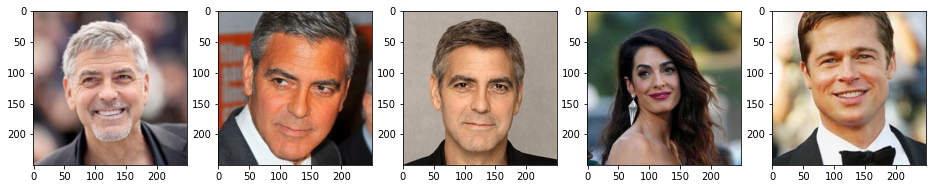

In [42]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(1, 5, 1)
ax.imshow(img_a1)
ax = fig.add_subplot(1, 5, 2)
ax.imshow(img_a2)
ax = fig.add_subplot(1, 5, 3)
ax.imshow(img_a3)
ax = fig.add_subplot(1, 5, 4)
ax.imshow(img_b1)
ax = fig.add_subplot(1, 5, 5)
ax.imshow(img_c1)
plt.show()

## Получение эмбеддингов для новых данных

In [43]:
new_embs = model(np.stack((img_a1, img_a2, img_a3, img_b1, img_c1), axis=0))

## Вычисление расстояний между эмбеддингами

In [44]:
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

emb1 = new_embs[0,:]
emb2 = new_embs[1,:]
emb3 = new_embs[2,:]
emb4 = new_embs[3,:]
emb5 = new_embs[4,:]

print('A1 <-> A2: ', diff(emb1, emb2))
print('A1 <-> A3: ', diff(emb1, emb3))
print('A2 <-> A3: ', diff(emb2, emb3))
print('A3 <-> B1: ', diff(emb3, emb4))
print('A3 <-> C1: ', diff(emb3, emb5))

A1 <-> A2:  16.88275013726335
A1 <-> A3:  19.596505052021552
A2 <-> A3:  11.922548847478371
A3 <-> B1:  15.37152655839203
A3 <-> C1:  10.022962527717603
